- - -

#### _Extracting lineage metrics from PhysiCell output for informed ABM development._

- - -

_Citations:_

elmar bucher, godzilla-but-nicer, Randy Heiland, Paul Macklin, & Patrick G Wall. (2023). elmbeech/physicelldataloader: 2023-07-23 (v3.2.9). Zenodo. https://doi.org/10.5281/zenodo.8176400

Ghaffarizadeh, A., Heiland, R., Friedman, S. H., Mumenthaler, S. M., & Macklin, P. (2018). PhysiCell: An open source physics-based cell simulator for 3-D multicellular systems. PLoS computational biology, 14(2), e1005991.

Ghaffarizadeh, A., Friedman, S. H., & Macklin, P. (2016). BioFVM: an efficient, parallelized diffusive transport solver for 3-D biological simulations. Bioinformatics, 32(8), 1256-1258.

- - -

# Install libraries

In [1]:
# for loading PhysiCell output
## !pip3 install -U pcdl[all]

# for data visualization
## !pip install plotly==5.22.0

# for HTML output
## !pip install jinja2==3.0.3
## !pip install nbconvert==6.4.4
## !pip install pretty-jupyter 

%load_ext pretty_jupyter

# Load libraries

In [2]:
import pcdl

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA

import json

import ipykernel # for debugging
from IPython.display import display, HTML

from scipy.spatial import KDTree

import plotly.express as px
import plotly.graph_objects as go

import plotly.io as pio
pio.renderers.default = "notebook"


import networkx as nx

import collections

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation


# Load data

Output is in the `output_lineage_attempt2` folder.

In [4]:
# -.-|m { output: false }

output_path = "../output_lineage_attempt8/"

# MultiCellular Data Standard // https://www.biorxiv.org/content/10.1101/090456v2

# TimeSeries -- the entirety of the simulation
mcds_ts = pcdl.TimeSeries(output_path) 
all_mcds = mcds_ts.read_mcds()

# TimeStep -- a "snapshot" of the simulation
# mcds = pcdl.TimeStep(file_48_path)

reading: ../output_lineage_attempt8/PhysiCell_settings.xml
Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['cycling_contact_halfmax', 'cycling_entry_threshold_resource', 'cycling_pressure_halfmax', 'damage_halfmax', 'debris_sensitivity', 'differentiation_contact_halfmax', 'inflammation_sensitivity', 'migration_bias_halfmax', 'migration_speed_halfmax', 'necrosis_saturation_resource', 'necrosis_threshold_resource', 'quorum_sensitivity', 'relative_max_damage_death', 'relative_max_toxicity', 'secretion_halfmax', 'toxicity_halfmax']
reading: ../output_lineage_attempt8/output00000000.xml
working on metadata ...
working on mesh data ...
reading: ../output_lineage_attempt8/initial_mesh0.mat
working on microenvironment data ...
reading: ../output_lineage_attempt8/output00000000_microenvironment0.mat
parsing: resource data
parsing: toxin data
parsing: quorum data
parsing: pro-inflammatory data
parsing: debris data
working on discrete cell data ..

In [5]:
print(len(all_mcds))

33


In [6]:
mcds_20 = all_mcds[20]
mcds_20.get_time() # corresponds to snapshot00000288.svg

3600.0

# Prepare data

In [7]:
# variables that have only 1 state carry no information, 
# so output variables with at least 2 states

df_cell = mcds_20.get_cell_df(states=2)
# print("\n".join(list(df_cell)))

In [8]:
display(df_cell)

,cell_count_voxel,cell_density_micron3,cytoplasmic_volume,death_rates_1,debris,debris_internalized_total_substrates,debris_net_export_rates,elapsed_time_in_phase,fluid_fraction,generation,...,resource_internalized_total_substrates,runtime,surface_area,time,total_volume,toxin,toxin_internalized_total_substrates,voxel_i,voxel_j,voxel_k
ID,,,,,,,,,,,,,,,,,,,,,
0,1,0.000125,29.591612,0.0028,0.052363,-1559995.0,500.0,1668.0,0.998584,0.0,...,69571.203579,2.180965,190.508312,3600.0,247.254786,1.524737e-108,-47401.0,8,39,0
1,1,0.000125,29.288518,0.0028,0.078042,-1520995.0,500.0,1590.0,0.998573,0.0,...,67648.370209,2.180965,198.968264,3600.0,263.906162,1.559144e-108,-55201.0,20,31,0
2,1,0.000125,30.370127,0.0028,0.065715,-1691995.0,500.0,1932.0,0.998555,0.0,...,68015.317717,2.180965,164.462189,3600.0,198.322923,1.659712e-108,-21001.0,22,14,0
3,3,0.000375,30.545574,0.0028,0.084493,-1736995.0,500.0,2022.0,0.998523,0.0,...,66315.016797,2.180965,156.424996,3600.0,183.964083,1.668021e-108,-12001.0,32,15,0
4,1,0.000125,30.315513,0.0028,0.064940,-1679995.0,500.0,1908.0,0.998562,0.0,...,67598.362209,2.180965,166.674532,3600.0,202.338105,1.662845e-108,-23401.0,33,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,1,0.000125,30.694412,0.0028,0.074438,-1790995.0,500.0,2130.0,0.998471,0.0,...,62710.859554,2.180965,147.298504,3600.0,168.101395,1.601161e-108,-1201.0,24,24,0
89,1,0.000125,30.545574,0.0028,0.049370,-1736995.0,500.0,2022.0,0.998523,0.0,...,68831.572894,2.180965,156.424996,3600.0,183.964083,1.565005e-108,-12001.0,12,27,0
90,1,0.000125,30.370127,0.0028,0.052075,-1691995.0,500.0,1932.0,0.998555,0.0,...,68464.224404,2.180965,164.462189,3600.0,198.322923,1.691195e-108,-21001.0,33,11,0


In [9]:
print(str(df_cell.columns))

Index(['cell_count_voxel', 'cell_density_micron3', 'cytoplasmic_volume',
       'death_rates_1', 'debris', 'debris_internalized_total_substrates',
       'debris_net_export_rates', 'elapsed_time_in_phase', 'fluid_fraction',
       'generation', 'mesh_center_m', 'mesh_center_n', 'mesh_center_p',
       'migration_bias_direction_vectorlength', 'migration_bias_direction_x',
       'migration_bias_direction_y', 'migration_speed', 'nuclear_radius',
       'nuclear_volume', 'parent_ID', 'position_vectorlength', 'position_x',
       'position_y', 'position_z', 'pressure', 'quorum',
       'quorum_internalized_total_substrates', 'radius', 'resource',
       'resource_internalized_total_substrates', 'runtime', 'surface_area',
       'time', 'total_volume', 'toxin', 'toxin_internalized_total_substrates',
       'voxel_i', 'voxel_j', 'voxel_k'],
      dtype='object')


In [10]:
df_cell = df_cell.astype({"parent_ID": int})
df_cell = df_cell[["parent_ID", "generation"]].sort_index()
display(df_cell)


,parent_ID,generation
ID,,
0,-1,0.0
1,-1,0.0
2,-1,0.0
3,-1,0.0
4,-1,0.0
...,...,...
96,-1,0.0
97,-1,0.0
99,-1,0.0


(array([1., 1.]), array([33., 56., 79.]), <BarContainer object of 2 artists>)

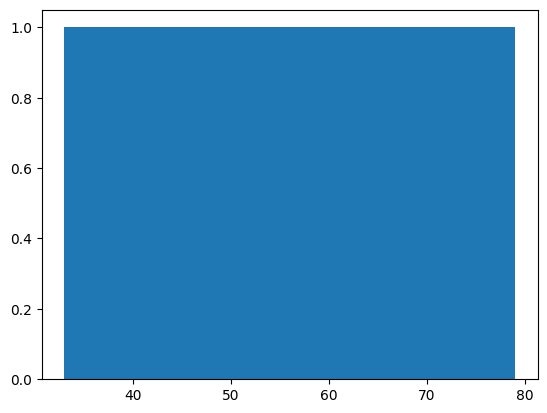

In [20]:
df_cell["ID"] = df_cell.index.copy()

# print(set(list(df_cell["generation"])))
# plt.hist(df_cell["parent_ID"])

parent_IDs = df_cell["parent_ID"]

parent_IDs = [value for value in parent_IDs if value != -1]

plt.hist(parent_IDs, bins=len(parent_IDs))

In [13]:
counter = collections.Counter(parent_IDs)
print(counter.most_common(4))

[(33, 1), (79, 1)]


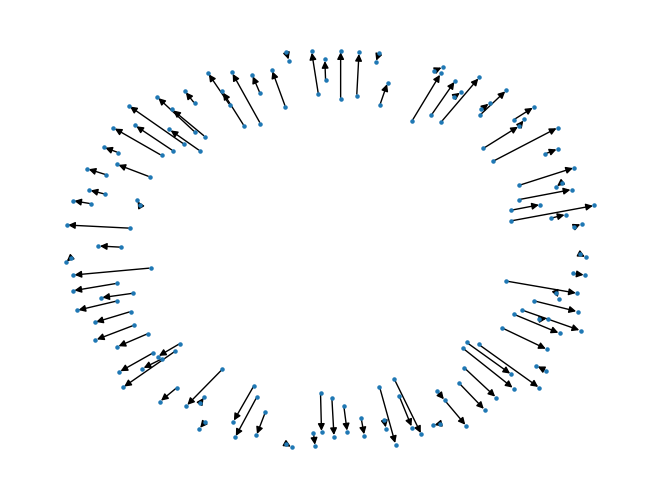

In [16]:
# color_dict = {"bacteria": "grey", "blood_vessel": "red", "stem": "yellow", "differentiated": "green", "macrophage": "blue", "CD8+_T_cell": "magenta", "neutrophil": "orange"}


def create_cell_ancestry(df):
    df.loc[df['parent_ID'] == -1, 'parent_ID'] = None

    G = nx.from_pandas_edgelist(df, source='parent_ID', target='ID', create_using=nx.DiGraph())
    nx.set_node_attributes(G, df.set_index('ID').to_dict('index'))

    # colors = []
    # for node in list(G.nodes()):
    #     try:
    #         colors.append(G.nodes[node]["cell_color"])
    #     except:
    #         colors.append("black")

    # fixed_pos = nx.random_layout(G, seed=seed)
    nx.draw_spring(G, node_size=5)

small_df = df_cell.copy()
create_cell_ancestry(small_df)

In [17]:
# fig, ax = plt.subplots()

# def animate(i): 
#     ax.clear()
    
#     timestep = all_mcds[i]
#     timestep_cell_df = timestep.get_cell_df()
    
#     timestep_cell_df["ID"] = timestep_cell_df.index.copy()

#     timestep_cell_df["cell_color"] = timestep_cell_df.apply(lambda row: color_dict[row.cell_type], axis = 1)
#     timestep_cell_df.loc[timestep_cell_df['parent_ID'] == -1, 'parent_ID'] = None

#     G = nx.from_pandas_edgelist(timestep_cell_df, source='parent_ID', target='ID', create_using=nx.DiGraph())
#     nx.set_node_attributes(G, timestep_cell_df.set_index('ID').to_dict('index'))

#     colors = []
#     for node in list(G.nodes()):
#         try:
#             colors.append(G.nodes[node]["cell_color"])
#         except:
#             colors.append("black")

#     nx.draw_spring(G, node_size=5, node_color=colors)
    
# anim = animation.FuncAnimation(fig, animate, frames=len(all_mcds), interval=1)

# writer = animation.PillowWriter(fps=15,
#                                 metadata=dict(artist='Me'),
#                                 bitrate=1800)
# anim.save('graph_anim.gif', writer=writer)

# Creating a lineage plot from a cell dataframe

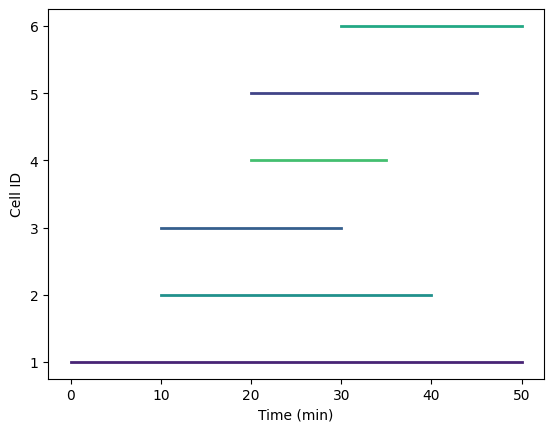

In [84]:
# Gantt chart (used for timelines / schedules) https://plotly.com/python/gantt/

# example
data = {
    'cell_id': [1, 2, 3, 4, 5, 6],
    'birth_time': [0, 10, 10, 20, 20, 30],
    'death_time': [50, 40, 30, 35, 45, 50],
    'feature': [0.1, 0.5, 0.3, 0.7, 0.2, 0.6]
}

df = pd.DataFrame(data)

fig, ax = plt.subplots()

for i, row in df.iterrows():
    ax.plot([row['birth_time'], row['death_time']], [i, i], color=plt.cm.viridis(row['feature']), lw=2) # discrete color scale (not suitable for continuous values)

ax.set_xlabel('Time (min)')
ax.set_ylabel('Cell ID')
ax.set_yticks(range(len(df)))
ax.set_yticklabels(df['cell_id'])

plt.show()

'''
NOTES

This only works / looks visually correct if the cell IDs are tailored such that they are
consecutive, or at least numerically ascending.

No parent ID taken into account.
'''


,ID,parent_ID,birth_time,death_time,density
0,1,-1,0,50,0.1
1,2,1,10,40,0.2
2,3,1,10,30,0.2
3,4,2,20,35,0.5
4,5,2,20,45,0.4
5,6,3,30,50,0.8
6,7,3,30,70,0.8


/var/folders/hb/6dk2l2613ngc433vnd63bg1r0000gn/T/ipykernel_37992/1172469406.py:32: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.



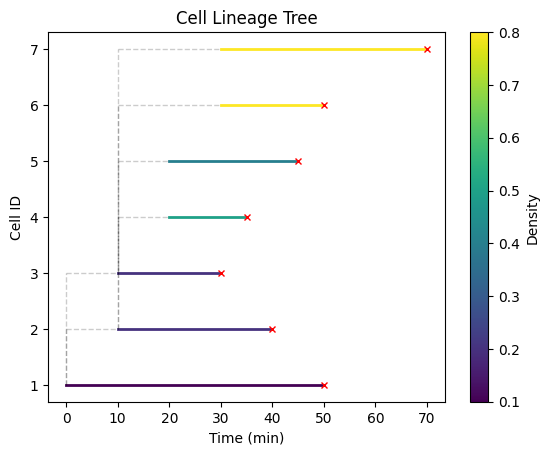

In [144]:
# example - with parent ID
data = {
    'ID': [1, 2, 3, 4, 5, 6, 7],
    'parent_ID': [-1, 1, 1, 2, 2, 3, 3],
    'birth_time': [0, 10, 10, 20, 20, 30, 30],
    'death_time': [50, 40, 30, 35, 45, 50, 70],
    'density': [0.1, 0.2, 0.2, 0.5, 0.4, 0.8, 0.8]
}

df = pd.DataFrame(data)
display(df)

# assign unique y positions
df['y_pos'] = range(1, len(df) + 1)

fig, ax = plt.subplots()

# color map for continuous feature of the data (ex. spatial metrics)
cmap = plt.cm.viridis
norm = matplotlib.colors.Normalize(vmin=df['density'].min(), vmax=df['density'].max())

colors = {}

# recursive plot of branches
# include y position, y step, so each cell is on its own "line" / position on the plot
def plot_branch(cell_id, parent_id, birth_time, death_time, y_pos):
    feature_value = df.loc[df['ID'] == cell_id]['density'].values[0]
    
    color = cmap(norm(feature_value))
    colors[cell_id] = color

    ax.plot([birth_time, death_time], [y_pos, y_pos], 'k-', color=color, lw=2) # span of a cell's life
    ax.plot([birth_time, death_time], [y_pos, y_pos], 'rx', markevery=[-1], markersize=5) # death

    # cells with parent ID -1 are cells that existed at the beginning of the simulation...
    # ...and thus do not have any parents/ancestors

    if parent_id != -1: 
        parent_birth_time = df.loc[df['ID'] == parent_id]['birth_time'].values[0]
        parent_y_pos = df.loc[df['ID'] == parent_id]['y_pos'].values[0]

        # connection from parent to child
        ax.plot([parent_birth_time, parent_birth_time], [parent_y_pos, y_pos], 'k--', alpha=0.2, lw=1) # vertical
        ax.plot([parent_birth_time, birth_time], [y_pos, y_pos], 'k--', alpha=0.2, lw=1) # horizontal

for row in df.itertuples():
    plot_branch(row.ID, row.parent_ID, row.birth_time, row.death_time, row.y_pos)

ax.set_xlabel('Time (min)')
ax.set_ylabel('Cell ID')
ax.set_title('Cell Lineage Tree')

# legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Density')

plt.show()